# Task 1: ideal mass-spring
Sam Greydanus

In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
import pdb
solve_ivp = scipy.integrate.solve_ivp


EXPERIMENT_DIR = './experiment-spring'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

## Set some notebook constants

In [2]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'spring',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

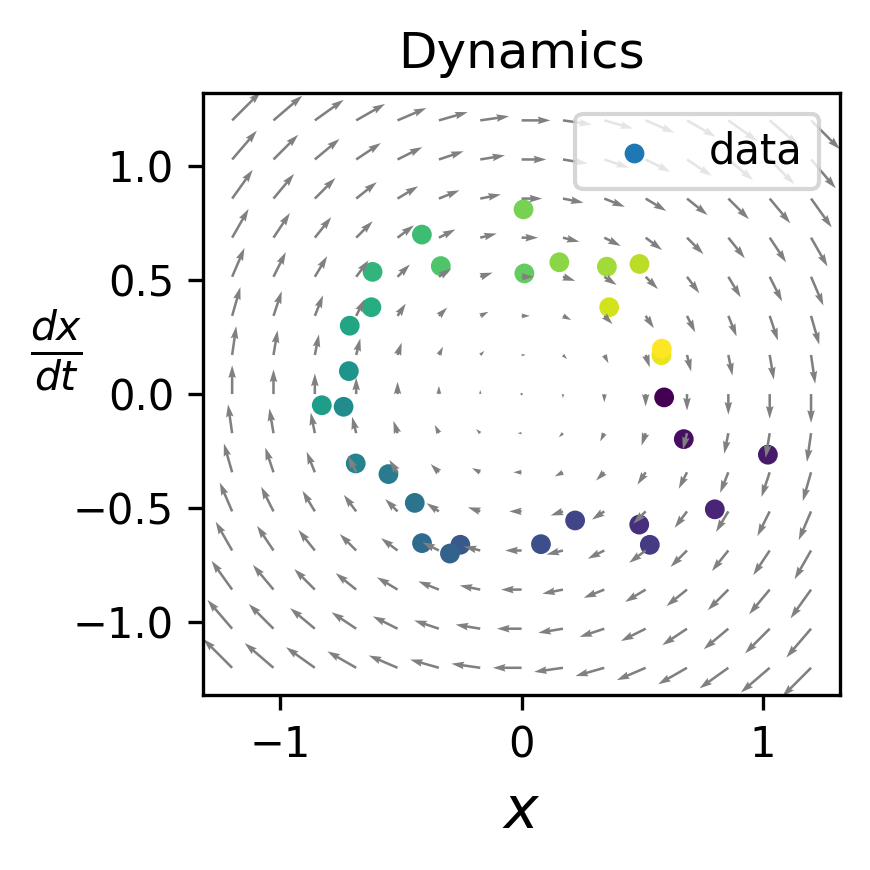

In [3]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
field = get_field(gridsize=15)
data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(radius=0.7, y0=np.array([1,0]))
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')

In [12]:
field

{'meta': {'gridsize': 10,
  'ymax': 1.2,
  'ymin': -1.2,
  'xmax': 1.2,
  'xmin': -1.2},
 'x': array([[-1.2       , -1.2       ],
        [-0.93333333, -1.2       ],
        [-0.66666667, -1.2       ],
        [-0.4       , -1.2       ],
        [-0.13333333, -1.2       ],
        [ 0.13333333, -1.2       ],
        [ 0.4       , -1.2       ],
        [ 0.66666667, -1.2       ],
        [ 0.93333333, -1.2       ],
        [ 1.2       , -1.2       ],
        [-1.2       , -0.93333333],
        [-0.93333333, -0.93333333],
        [-0.66666667, -0.93333333],
        [-0.4       , -0.93333333],
        [-0.13333333, -0.93333333],
        [ 0.13333333, -0.93333333],
        [ 0.4       , -0.93333333],
        [ 0.66666667, -0.93333333],
        [ 0.93333333, -0.93333333],
        [ 1.2       , -0.93333333],
        [-1.2       , -0.66666667],
        [-0.93333333, -0.66666667],
        [-0.66666667, -0.66666667],
        [-0.4       , -0.66666667],
        [-0.13333333, -0.66666667],
      

In [4]:
#############
data

{'x': array([[-0.08470211,  0.8053172 ],
        [ 0.40116634,  0.52705736],
        [ 0.29779712,  0.53407765],
        ...,
        [-0.78686947,  0.15827948],
        [-0.50998115,  0.46937257],
        [-0.89528671,  0.30024588]]),
 'test_x': array([[-0.84811449, -0.12756995],
        [-0.65057014,  0.11525937],
        [-0.74861258,  0.24465961],
        ...,
        [-0.20537879, -0.32200901],
        [-0.08230261, -0.20196125],
        [-0.35501897, -0.23141113]]),
 'dx': array([[ 1.25313759, -0.28426143],
        [ 1.16801816, -0.5356236 ],
        [ 1.03307799, -0.76413904],
        ...,
        [ 0.31037843,  1.57530498],
        [ 0.62736407,  1.47794962],
        [ 0.91758996,  1.31755408]]),
 'test_dx': array([[-0.3033807 ,  1.46951042],
        [ 0.00496201,  1.5004922 ],
        [ 0.313093  ,  1.46747193],
        ...,
        [-0.48151482,  0.10871766],
        [-0.44891211,  0.20531316],
        [-0.39716205,  0.29315151]])}

In [6]:
############################
print('x shape',data['x'].shape)
print('test_x shape',data['test_x'].shape)
print('dx shape',data['dx'].shape)
print('test_dx shape',data['test_dx'].shape)

x shape (750, 2)
test_x shape (750, 2)
dx shape (750, 2)
test_dx shape (750, 2)


## Construct models

In [4]:
def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/spring{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

In [6]:
args.__dict__

{'input_dim': 2,
 'hidden_dim': 200,
 'learn_rate': 0.001,
 'nonlinearity': 'tanh',
 'total_steps': 2000,
 'field_type': 'solenoidal',
 'print_every': 200,
 'name': 'spring',
 'gridsize': 10,
 'input_noise': 0.5,
 'seed': 0,
 'save_dir': '././experiment-spring',
 'fig_dir': './figures'}

## Get vector fields

In [5]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [6]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [7]:
base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)

In [ ]:
# get their vector fields
field = get_field(gridsize=args.gridsize)
data = get_dataset()
base_field = get_vector_field(base_model, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_model, gridsize=args.gridsize)


[29] > /home/jsbae/ClonedRepo/hamiltonian-nn/hnn.py(39)time_derivative()
-> F1, F2 = self.forward(x) # traditional forward pass
(Pdb++) sticky
> /home/jsbae/ClonedRepo/hamiltonian-nn/hnn.py(39)

  33         def time_derivative(self, x, t=None, separate_fields=False):                                               
  34             '''NEURAL ODE-STLE VECTOR FIELD'''                                                                     
  35             if self.baseline:                                                                                      
  36                 return self.differentiable_model(x) # Jsbae: same as just calling forward                          
  37             pdb.set_trace()                                                                                        
  38             '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''                                                             
  39  ->         F1, F2 = self.forward(x) # traditional forward pass           

(Pdb++) F1.shape
torch.Size([100, 1])
(Pdb++) next
[29] > /home/jsbae/ClonedRepo/hamiltonian-nn/hnn.py(42)time_derivative()
-> solenoidal_field = torch.zeros_like(x)
> /home/jsbae/ClonedRepo/hamiltonian-nn/hnn.py(42)

  33         def time_derivative(self, x, t=None, separate_fields=False):                                               
  34             '''NEURAL ODE-STLE VECTOR FIELD'''                                                                     
  35             if self.baseline:                                                                                      
  36                 return self.differentiable_model(x) # Jsbae: same as just calling forward                          
  37             pdb.set_trace()                                                                                        
  38             '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''                                                             
  39             F1, F2 = self.forward(x) # traditional 

(Pdb++) next
[29] > /home/jsbae/ClonedRepo/hamiltonian-nn/hnn.py(49)time_derivative()
-> dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] # gradients for solenoidal field
> /home/jsbae/ClonedRepo/hamiltonian-nn/hnn.py(49)

  33         def time_derivative(self, x, t=None, separate_fields=False):                                               
  34             '''NEURAL ODE-STLE VECTOR FIELD'''                                                                     
  35             if self.baseline:                                                                                      
  36                 return self.differentiable_model(x) # Jsbae: same as just calling forward                          
  37             pdb.set_trace()                                                                                        
  38             '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''                                                             
  39             F1, F2 = self.forward(

(Pdb++) F2.sum()
tensor(-979.5395, grad_fn=<SumBackward0>)
(Pdb++) next
[29] > /home/jsbae/ClonedRepo/hamiltonian-nn/hnn.py(52)time_derivative()
-> if separate_fields:
> /home/jsbae/ClonedRepo/hamiltonian-nn/hnn.py(52)

  33         def time_derivative(self, x, t=None, separate_fields=False):                                               
  34             '''NEURAL ODE-STLE VECTOR FIELD'''                                                                     
  35             if self.baseline:                                                                                      
  36                 return self.differentiable_model(x) # Jsbae: same as just calling forward                          
  37             pdb.set_trace()                                                                                        
  38             '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''                                                             
  39             F1, F2 = self.forward(x) # traditiona

(Pdb++) kk = torch.autograd.grad(F2.sum(), x, create_graph=True)
(Pdb++) kk.shape
*** AttributeError: 'tuple' object has no attribute 'shape'
(Pdb++) kk.shape()
*** AttributeError: 'tuple' object has no attribute 'shape'
(Pdb++) len(kk)
1
(Pdb++) kk
(tensor([[-1.8104, -1.8712],
        [-1.5395, -1.9738],
        [-1.1753, -2.0442],
        [-0.7419, -2.0804],
        [-0.2664, -2.0854],
        [ 0.2272, -2.0639],
        [ 0.7173, -2.0191],
        [ 1.1765, -1.9521],
        [ 1.5659, -1.8642],
        [ 1.8412, -1.7585],
        [-1.9164, -1.5807],
        [-1.6189, -1.6636],
        [-1.2233, -1.7199],
        [-0.7606, -1.7494],
        [-0.2608, -1.7565],
        [ 0.2533, -1.7457],
        [ 0.7625, -1.7192],
        [ 1.2410, -1.6766],
        [ 1.6493, -1.6167],
        [ 1.9405, -1.5400],
        [-1.9962, -1.1835],
        [-1.6784, -1.2403],
        [-1.2593, -1.2791],
        [-0.7763, -1.3005],
        [-0.2609, -1.3080],
        [ 0.2658, -1.3054],
        [ 0.7873, -1.

(Pdb++) kk
(tensor([[-1.8104, -1.8712],
        [-1.5395, -1.9738],
        [-1.1753, -2.0442],
        [-0.7419, -2.0804],
        [-0.2664, -2.0854],
        [ 0.2272, -2.0639],
        [ 0.7173, -2.0191],
        [ 1.1765, -1.9521],
        [ 1.5659, -1.8642],
        [ 1.8412, -1.7585],
        [-1.9164, -1.5807],
        [-1.6189, -1.6636],
        [-1.2233, -1.7199],
        [-0.7606, -1.7494],
        [-0.2608, -1.7565],
        [ 0.2533, -1.7457],
        [ 0.7625, -1.7192],
        [ 1.2410, -1.6766],
        [ 1.6493, -1.6167],
        [ 1.9405, -1.5400],
        [-1.9962, -1.1835],
        [-1.6784, -1.2403],
        [-1.2593, -1.2791],
        [-0.7763, -1.3005],
        [-0.2609, -1.3080],
        [ 0.2658, -1.3054],
        [ 0.7873, -1.2939],
        [ 1.2796, -1.2724],
        [ 1.7033, -1.2389],
        [ 2.0093, -1.1920],
        [-2.0442, -0.7291],
        [-1.7151, -0.7578],
        [-1.2824, -0.7789],
        [-0.7877, -0.7916],
        [-0.2638, -0.7976],
        

In [10]:
# integrate along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([1., 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

## Plot results

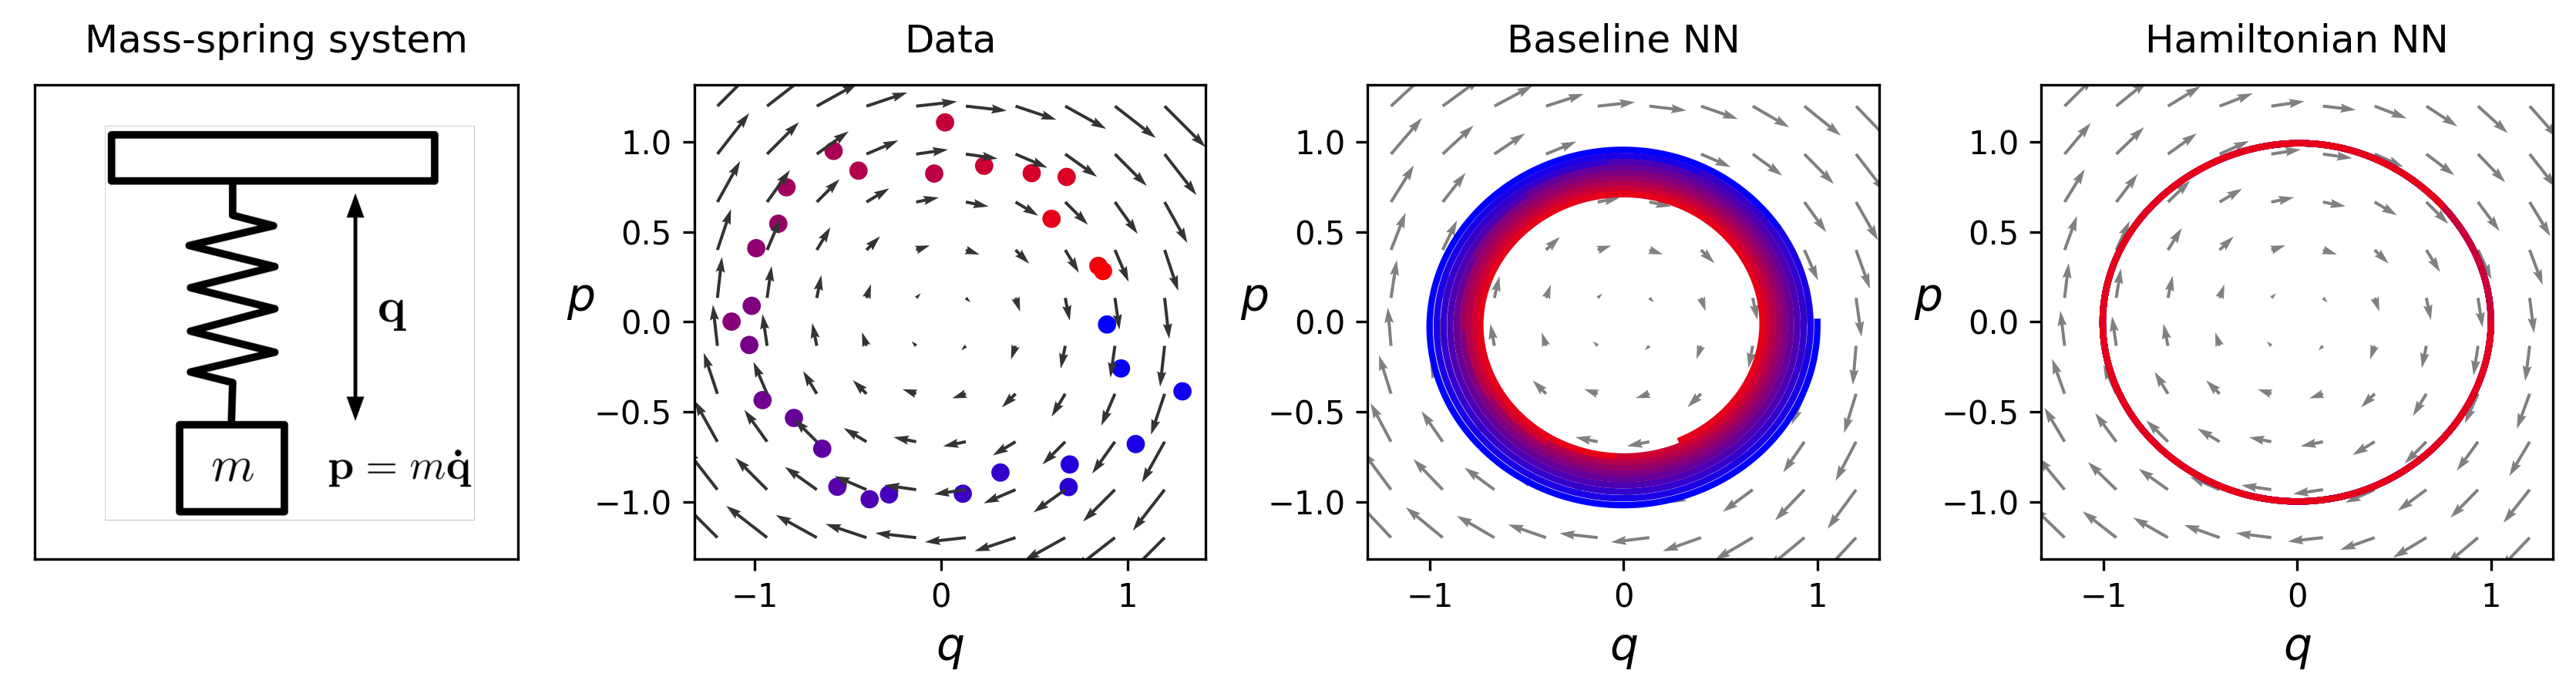

In [11]:
###### PLOT ######
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white', dpi=DPI)

# plot physical system
fig.add_subplot(1, 4, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/mass-spring.png')
plt.imshow(schema)
plt.title("Mass-spring system", pad=10)

# plot dynamics
fig.add_subplot(1, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(radius=1, y0=np.array([1,0]))
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=22, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

plt.tight_layout() ; plt.show()
fig.savefig('{}/spring{}.{}'.format(args.fig_dir, RK4, FORMAT))

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [ ]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None, noise_std=0.1):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T
    
    # rescale time to compensate for noise effects, as described in appendix
    t_span[1] *= 1 + .9*noise_std
    t_eval *= 1 + .9*noise_std

    # integrate along baseline vector field
    base_path = integrate_model(base_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    
    return true_x, base_x, hnn_x

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

In [ ]:
x0 = np.asarray([1, 0])

# integration
t_span=[0,20]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.xlim(-1.2,2) ; plt.ylim(-1.2,2)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
base_hq = hnn_model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('{}/spring-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [ ]:

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Title", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')

plt.subplot(1,4,2)
plt.title("Title", pad=tpad) ; plt.xlabel('$q$')

plt.subplot(1,4,3)
plt.title("Title", pad=tpad) ; plt.xlabel('$q$')
plt.plot(t_eval, true_hq)

plt.subplot(1,4,4)
plt.title("Title", pad=tpad) ; plt.xlabel('$q$')


plt.tight_layout() ; plt.show()
fig.savefig('{}/blank{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [ ]:
splits = 5
samples = 3
losses = {'base_energy' : [], 'hnn_energy' : []}
t_eval = np.linspace(t_span[0], t_span[1], 100)

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(2)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    
    losses['base_energy'] += [ energy_loss(true_x, base_x) ]
    losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
    print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

In [ ]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_energy']), bootstrap_conf(losses['base_energy'], splits),
          np.mean(losses['hnn_energy']), bootstrap_conf(losses['hnn_energy'], splits))
     )